In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random, math
import io 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import svm
import time
from sklearn import datasets
from sklearn.cluster import KMeans as KM
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.tree import DecisionTreeClassifier as DT

# Utilities

In [2]:

class Solution():    
    #structure of the solution 
    def __init__(self):
        self.num_features = None
        self.num_agents = None
        self.max_iter = None
        self.obj_function = None
        self.execution_time = None
        self.convergence_curve = {}
        self.best_agent = None
        self.best_fitness = None
        self.best_accuracy = None
        self.final_population = None
        self.final_fitness = None
        self.final_accuracy = None


class Data():
    # structure of the training data
    def __init__(self):
        self.train_X = None
        self.train_Y = None
        self.val_X = None
        self.val_Y = None



def initialize(num_agents, num_features):
    # define min and max number of features
    min_features = int(0.3 * num_features)
    max_features = int(0.6 * num_features)

    # initialize the agents with zeros
    agents = np.zeros((num_agents, num_features))

    # select random features for each agent
    for agent_no in range(num_agents):

        # find random indices
        cur_count = np.random.randint(min_features, max_features)
        temp_vec = np.random.rand(1, num_features)
        temp_idx = np.argsort(temp_vec)[0][0:cur_count]

        # select the features with the ranom indices
        agents[agent_no][temp_idx] = 1   

    return agents



def sort_agents(agents, obj_function, data):
    # sort the agents according to fitness
    train_X, val_X, train_Y, val_Y = data.train_X, data.val_X, data.train_Y, data.val_Y

    # if there is only one agent
    if len(agents.shape) == 1:
        num_agents = 1
        fitness = obj_function(agents, train_X, val_X, train_Y, val_Y)
        return agents, fitness

    # for multiple agents
    else:
        num_agents = agents.shape[0]
        fitness = np.zeros(num_agents)
        for id, agent in enumerate(agents):
            fitness[id] = obj_function(agent, train_X, val_X, train_Y, val_Y)
        idx = np.argsort(-fitness)
        sorted_agents = agents[idx].copy()
        sorted_fitness = fitness[idx].copy()

    return sorted_agents, sorted_fitness



def display(agents, fitness, agent_name='Agent'):
    # display the population
    print('\nNumber of agents: {}'.format(agents.shape[0]))
    print('\n------------- Best Agent ---------------')
    print('Fitness: {}'.format(fitness[0]))
    print('Number of Features: {}'.format(int(np.sum(agents[0]))))
    print('----------------------------------------\n')

    for id, agent in enumerate(agents):
        print('{} {} - Fitness: {}, Number of Features: {}'.format(agent_name, id+1, fitness[id], int(np.sum(agent))))

    print('================================================================================\n')



def compute_accuracy(agent, train_X, test_X, train_Y, test_Y): 
    # compute classification accuracy of the given agents
    cols = np.flatnonzero(agent)     
    if(cols.shape[0] == 0):
        return 0    
    clf = DT()

    train_data = train_X[:,cols]
    train_label = train_Y
    test_data = test_X[:,cols]
    test_label = test_Y

    clf.fit(train_data,train_label)
    acc = clf.score(test_data,test_label)

    return acc
        

def compute_fitness(agent, train_X, test_X, train_Y, test_Y):
    # compute a basic fitness measure
    weight_acc = 0.7
    weight_feat = 0.3 
    num_features = agent.shape[0]
    
    acc = compute_accuracy(agent, train_X, test_X, train_Y, test_Y)
    feat = (num_features - np.sum(agent))/num_features

    fitness = weight_acc * acc + weight_feat * feat
    
    return fitness

# transfer function

In [3]:
import numpy as np

def sigmoid(val):
    if val < 0:
        return 1 - 1/(1 + np.exp(2*val))
    else:
        return 1/(1 + np.exp(-2*val))

# def v_func(val):
#     return abs(val/(np.sqrt(1 + val*val)))

def v_func(val):
    temp=(math.pi/2)*val
    temp=np.arctan(temp)
    temp=(2/math.pi)*temp
    return abs(temp)
# def v_func(val):
#     return abs(np.tanh(val))

# def v_func(val):
#     temp = (math.pi)**(0.5)
#     temp /= 2
#     temp *= temp
#     temp = math.erf(temp)
#     return abs(temp)


def u_func(val):
    alpha, beta = 2, 1.5
    return alpha * np.power(abs(val), beta)

def z_func(val):
    return math.sqrt( 1 - (1 / 2**val))


def get_trans_function(shape):
    if (shape.lower() == 's'):
        return sigmoid

    elif (shape.lower() == 'v'):
        return v_func

    elif(shape.lower() == 'u'):
        return u_func
    elif (shape.lower() == 'z'):
        return z_func

    else:
        print('\n[Error!] We don\'t currently support {}-shaped transfer functions...\n'.format(shape))
        exit(1)


## PSO

In [4]:


def PSO(num_agents, max_iter, train_data, train_label, obj_function=compute_fitness, trans_func_shape='u', save_conv_graph=False):
    
    # Particle Swarm Optimizer
    ############################### Parameters ####################################
    #                                                                             #
    #   num_agents: number of particles                                           #
    #   max_iter: maximum number of generations                                   #
    #   train_data: training samples of data                                      #
    #   train_label: class labels for the training samples                        #                
    #   obj_function: the function to maximize while doing feature selection      #
    #   trans_function_shape: shape of the transfer function used                 #
    #   save_conv_graph: boolean value for saving convergence graph               #
    #                                                                             #
    ###############################################################################
    
    short_name = 'PSO'
    agent_name = 'Particle'
    train_data, train_label = np.array(train_data), np.array(train_label)
    num_features = train_data.shape[1]
    trans_function = get_trans_function(trans_func_shape)

    # initialize particles and Leader (the agent with the max fitness)
    particles = initialize(num_agents, num_features)
    fitness = np.zeros(num_agents)
    accuracy = np.zeros(num_agents)
    Leader_agent = np.zeros((1, num_features))
    Leader_fitness = float("-inf")
    Leader_accuracy = float("-inf")

    # initialize convergence curves
    convergence_curve = {}
    convergence_curve['fitness'] = np.zeros(max_iter)
    convergence_curve['feature_count'] = np.zeros(max_iter)

    # format the data
    data = Data()
    data.train_X, data.val_X, data.train_Y, data.val_Y = train_test_split(train_data, train_label, stratify=train_label, test_size=0.2)

    # create a solution object
    solution = Solution()
    solution.num_agents = num_agents
    solution.max_iter = max_iter
    solution.num_features = num_features
    solution.obj_function = obj_function

    # rank initial particles
    particles, fitness = sort_agents(particles, obj_function, data)

    # start timer
    start_time = time.time()

    # initialize global and local best particles
    globalBestParticle = [0 for i in range(num_features)]
    globalBestFitness = float("-inf")
    localBestParticle = [ [ 0 for i in range(num_features) ] for j in range(num_agents) ] 
    localBestFitness = [float("-inf") for i in range(num_agents) ]
    weight = 1.0 
    c1_i = 2.05
    c1_f = 0.5
    c2_i = 0.5
    c2_f = 2.05
    
    velocity = [ [ 0.0 for i in range(num_features) ] for j in range(num_agents) ]
    
    for iter_no in range(max_iter):
#         print('\n================================================================================')
#         print('                          Iteration - {}'.format(iter_no+1))
#         print('================================================================================\n')
        
        # update weight
        weight = 1.0 - (iter_no / max_iter)
        c1 = ((c1_f - c1_i) * (iter_no / max_iter)) + c1_i
        c2 = ((c2_f - c2_i) * (iter_no / max_iter)) + c2_i
        # update the velocity
        for i in range(num_agents):
            for j in range(num_features):
                velocity[i][j] = (weight*velocity[i][j])
                r1, r2 = np.random.random(2)
                velocity[i][j] = velocity[i][j] +  c1 * (r1 * (localBestParticle[i][j] - particles[i][j]))
                velocity[i][j] = velocity[i][j] +  c2 * (r2 * (globalBestParticle[j] - particles[i][j]))
       
        # updating position of particles
        for i in range(num_agents):
            for j in range(num_features):
                trans_value = trans_function(velocity[i][j])
                if (np.random.random()  < trans_value): 
                    particles[i][j] = 0
                else:
                    particles[i][j] = 1
        
    
#         for i in range(num_agents):
#             for j in range(num_features):
#                 particles[i][j] += velocity[i][j]; 
#                 trans_value = trans_function(particles[i][j])
#                 if (np.random.random() < trans_value): 
#                     particles[i][j] = 1
#                 else:
#                     particles[i][j] = 0

        # updating fitness of particles
        particles, fitness = sort_agents(particles, obj_function, data)
        #display(particles, fitness, agent_name)
        
        
        # updating the global best and local best particles
        for i in range(num_agents):
            if fitness[i]>localBestFitness[i]:
                localBestFitness[i]=fitness[i]
                localBestParticle[i]=particles[i][:]

            if fitness[i]>globalBestFitness:
                globalBestFitness=fitness[i]
                globalBestParticle=particles[i][:]

        # update Leader (best agent)
        if globalBestFitness > Leader_fitness:
            Leader_agent = globalBestParticle.copy()
            Leader_fitness = globalBestFitness.copy()

        convergence_curve['fitness'][iter_no] = Leader_fitness
        convergence_curve['feature_count'][iter_no] = int(np.sum(Leader_agent))

    # compute final accuracy
    Leader_agent, Leader_accuracy = sort_agents(Leader_agent, compute_accuracy, data)
    particles, accuracy = sort_agents(particles, compute_accuracy, data)

    print('\n================================================================================')
    print('                                    Final Result                                  ')
    print('================================================================================\n')
    print('Leader ' + agent_name + ' Dimension : {}'.format(int(np.sum(Leader_agent))))
    print('Leader ' + agent_name + ' Fitness : {}'.format(Leader_fitness))
    print('Leader ' + agent_name + ' Classification Accuracy : {}'.format(Leader_accuracy))
    print('\n================================================================================\n')
    
    print(Leader_agent)
    result = np.where(Leader_agent == 1)
    print('ELEMENTS   :' ,result[0]+1, sep='\n')
    
    # stop timer
    end_time = time.time()
    exec_time = end_time - start_time
    print('Time Taken for this : {}'.format(exec_time))
    print('Transfer fucntion : '+ trans_func_shape )
    
    # plot convergence curves
    iters = np.arange(max_iter)+1
    fig, axes = plt.subplots(2, 1)
    fig.tight_layout(pad=5)
    fig.suptitle('Convergence Curves'+ trans_func_shape)

    axes[0].set_title('Convergence of Fitness over Iterations')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Fitness')
    axes[0].plot(iters, convergence_curve['fitness'])

    axes[1].set_title('Convergence of Feature Count over Iterations')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Number of Selected Features')
    axes[1].plot(iters, convergence_curve['feature_count'])

    if(save_conv_graph):
        plt.savefig('convergence_graph_'+ short_name + '.jpg')
    plt.show()

    # update attributes of solution
    solution.best_agent = Leader_agent
    solution.best_fitness = Leader_fitness
    solution.best_accuracy = Leader_accuracy
    solution.convergence_curve = convergence_curve
    solution.final_particles = particles
    solution.final_fitness = fitness
    solution.final_accuracy = accuracy
    solution.execution_time = exec_time

    return solution





                                    Final Result                                  

Leader Particle Dimension : 1
Leader Particle Fitness : 0.9104622871046228
Leader Particle Classification Accuracy : 0.9197080291970803


[0. 0. 0. 0. 0. 1. 0. 0. 0.]
ELEMENTS   :
[6]
Time Taken for this : 26.71078062057495
Transfer fucntion : u


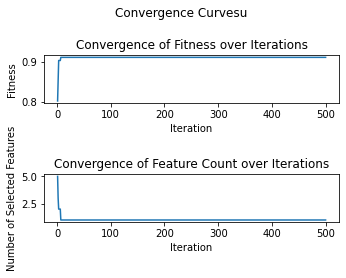

In [10]:
if __name__ == '__main__':
    df = pd.read_csv('breast.csv')
    X=df.drop('Class',axis=1)
    Y=df['Class']
    PSO(50, 500,X, Y, save_conv_graph=True)

In [6]:
#print(X)
#print(Y)
# PSO(100, 50, X, Y, save_conv_graph=True)
    
#cancer = datasets.load_breast_cancer()
    #print(cancer.data)
    #PSO(10, 10, cancer.data, cancer.target, save_conv_graph=True)